# Convolutional Neural Networks with Keras (1)

## CNN from scratch

We will train our CNN to distinguish ants and bees

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://medium.com/towards-data-science/transfer-learning-using-keras-d804b2e04ef8

http://cs231n.github.io/transfer-learning/

http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

The dataset can be downloaded from

It uses the following directory structure:

In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import numpy as np


import os
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


Using TensorFlow backend.


In [2]:
train_data_dir = 'data/train'
test_data_dir = 'data/test'
num_epochs = 1
batch_size = 16
nb_train_samples = 235
nb_test_samples = 148

In [3]:
target_width = 500
target_height = 375

In [4]:
#heights = []
#widths = []
#import statistics

rootdir = './data'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        path = (os.path.join(subdir, file))
        with Image.open(path) as img:
            width, height = img.size
            
            #heights.append(height)
            #widths.append(width)

            if width > 500 or width < 300: os.remove(path)
            if not (width == target_width and height == target_height):
              resized =  img.crop((0,0,target_width,target_height))
              resized.save(path)

#print("widths(min/max/median): {} / {} / {} ".format(
#    min(widths), max(widths), statistics.median(widths)))
#print("heights(min/max/median): {} / {} / {} ".format(
#    min(heights), max(heights), statistics.median(heights)))

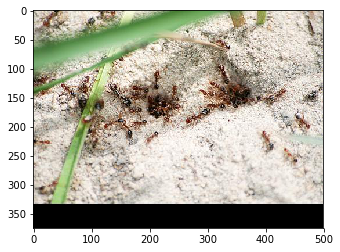

In [5]:
path = 'data/train/ants/1030023514_aad5c608f9.jpg'

img_mpl = mpimg.imread(path)
plt.imshow(img_mpl)     


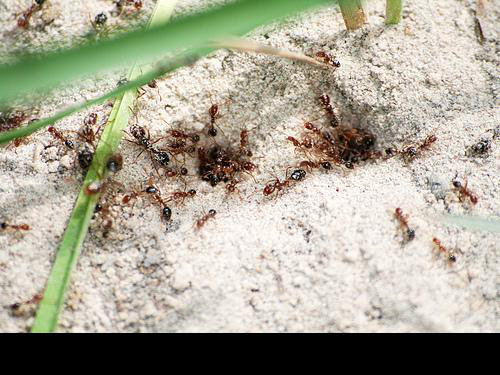

In [6]:
img = load_img(path)
img

In [7]:
img_array = img_to_array(img)  
img_array.shape

(375, 500, 3)

In [8]:
K.image_data_format()

'channels_last'

In [9]:
img_array = np.expand_dims(img_array, axis=0)
img_array.shape

(1, 375, 500, 3)

### Data augmentation

In [10]:
# rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
# width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
# rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
# shear_range is for randomly applying shearing transformations
# zoom_range is for randomly zooming inside pictures
# horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
# fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img(path)  
img_array = img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape) 

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(img_array, batch_size=1,
                          save_to_dir='preview', save_prefix='deform', save_format='jpg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [11]:
# Input shape
# 4D tensor with shape: (samples, channels, rows, cols) if data_format='channels_first' or
# 4D tensor with shape: (samples, rows, cols, channels) if data_format='channels_last'.

# !!! this is opposite from PIL convention width, height!
input_shape = (target_height, target_width, 3)
target_size = (target_height, target_width)

In [12]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
     # rotation_range=40,
     # width_shift_range=0.2,
     # height_shift_range=0.2,
     rescale=1. / 255,
     shear_range=0.2,
     zoom_range=0.2,
     horizontal_flip=True)

In [13]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [14]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary')

Found 235 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [15]:
model_exists = True
model_name = "cnn_from_scratch.h5"

In [16]:
if not model_exists:
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    model.summary()


In [17]:
if not model_exists:
    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=num_epochs,
        validation_data=validation_generator,
        validation_steps=nb_test_samples // batch_size)

In [18]:
if not model_exists:
    model.save(model_name)

In [19]:
if model_exists:
    model = load_model(model_name)
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 498, 373, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 498, 373, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 249, 186, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 247, 184, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 247, 184, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 123, 92, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 121, 90, 64)       18496     
__________

In [20]:
test_img_path = 'data/test/ants/10308379_1b6c72e180.jpg'
img = load_img(test_img_path) 
#candidate = np.expand_dims(img_to_array(img)/255, axis=0)
#pred, prob = model.predict_classes(candidate, verbose=0), model.predict_proba(candidate, batch_size=1, verbose=0)
#class_ = "ant" if pred[0,0] == 0 else "bee"
#conf = 1 - prob[0,0] if pred[0,0] == 0 else prob[0,0]
#print('Diagnosis: {} (confidence: {:.2f})'.format(class_,conf))
img_to_array(img).shape



(375, 500, 3)

In [21]:
test_img_path = 'data/test/bees/'
img = load_img(test_img_path) 
candidate = np.expand_dims(img_to_array(img)/255, axis=0)
pred, prob = test_model.predict_classes(candidate, verbose=0), test_model.predict_proba(candidate, batch_size=1, verbose=0)
class_ = "crack" if pred[0,0] == 0 else "no crack"
conf = 1 - prob[0,0] if pred[0,0] == 0 else prob[0,0]
print('Diagnosis: {} (confidence: {:.2f})'.format(class_,conf))
img



IsADirectoryError: [Errno 21] Is a directory: 'data/test/bees/'

In [ ]:
def score_img(img_path):
    img = load_img(img_path, grayscale=True) 
    candidate = np.expand_dims(img_to_array(img)/255, axis=0)
    pred = test_model.predict_classes(candidate, verbose=0)
    return pred[0,0]

In [ ]:
ants_total = 837
num_cracks_found = 0
for imgfile in os.listdir('data/test/crack'):
    score = score_img('data/test/crack/' + imgfile)
    if score == 0: num_cracks_found = num_cracks_found + 1
print('Found crack in {} of {} images'.format(num_cracks_found, cracks_total))

In [ ]:
no_cracks_total = 772
num_no_cracks_found = 0
for imgfile in os.listdir('data/test/nocrack'):
    score = score_img('data/test/nocrack/' + imgfile)
    if score == 1: num_no_cracks_found = num_no_cracks_found + 1
print('Correctly said "no crack" in {} of {} images'.format(num_no_cracks_found, no_cracks_total))

In [ ]:
true_positives = num_cracks_found
false_negatives = cracks_total - true_positives
true_negatives = num_no_cracks_found
false_positives = no_cracks_total - true_negatives

accuracy = (true_positives + true_negatives) / (cracks_total + no_cracks_total)
sensitivity = true_positives / (true_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)

print('Accuracy: {:.3f}, sensitivity: {:.3f}, precision: {:.3f}'.format(accuracy, sensitivity, precision))